<a href="https://colab.research.google.com/github/HunterAlpha7/mv1/blob/main/CatBoost%2BRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flood Probability Prediction
### Ensemble: Random Forest + CatBoost
Target: `FloodProbability` (continuous 0–1)
- 70% train | 10% validation | 20% test

In [ ]:
!pip install -q catboost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style="whitegrid")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Research/Flood prediction database/flood.csv")
print(f"Shape: {df.shape}")
df.head()

Shape: (50000, 21)


,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,3,8,6,6,4,4,6,2,3,2,...,10,7,4,2,3,4,3,2,6,0.450
1,8,4,5,7,7,9,1,5,5,4,...,9,2,6,2,1,1,9,1,3,0.475
2,3,10,4,1,7,5,4,7,4,9,...,7,4,4,8,6,1,8,3,6,0.515
3,4,4,2,7,3,4,1,4,6,4,...,4,2,6,6,8,8,6,6,10,0.520
4,3,7,5,2,5,8,5,2,7,5,...,7,6,5,3,3,4,4,3,4,0.475


In [ ]:
X = df.drop('FloodProbability', axis=1)
y = df['FloodProbability']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

Train: 35000 | Val: 5000 | Test: 10000


In [ ]:
# Random Forest – The stable expert
rf = RandomForestRegressor(
    n_estimators=600,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    warm_start=False
)

# CatBoost – The genius self-correcting kid
cat = CatBoostRegressor(
    iterations=2500,
    learning_rate=0.025,
    depth=8,
    random_seed=42,
    verbose=200,
    loss_function='RMSE',
    eval_metric='RMSE'
)

# Train both
rf.fit(X_train, y_train)
cat.fit(X_train, y_train)

# Ensemble – just average them
ensemble = VotingRegressor([('rf', rf), ('cat', cat)])
ensemble.fit(X_train, y_train)

print("CatBoost + Random Forest ensemble ready!")

0:	learn: 0.0496061	total: 60.9ms	remaining: 2m 32s
200:	learn: 0.0190391	total: 1.9s	remaining: 21.7s
400:	learn: 0.0095631	total: 3.54s	remaining: 18.5s
600:	learn: 0.0053452	total: 7.76s	remaining: 24.5s
800:	learn: 0.0032840	total: 9.29s	remaining: 19.7s
1000:	learn: 0.0021729	total: 10.8s	remaining: 16.2s
1200:	learn: 0.0015810	total: 12.3s	remaining: 13.3s
1400:	learn: 0.0012769	total: 13.8s	remaining: 10.8s
1600:	learn: 0.0011157	total: 15.2s	remaining: 8.55s
1800:	learn: 0.0010285	total: 16.7s	remaining: 6.48s
2000:	learn: 0.0009736	total: 19.5s	remaining: 4.85s
2200:	learn: 0.0009344	total: 22.1s	remaining: 3.01s
2400:	learn: 0.0009044	total: 23.6s	remaining: 975ms
2499:	learn: 0.0008888	total: 24.4s	remaining: 0us
0:	learn: 0.0496061	total: 15ms	remaining: 37.4s
200:	learn: 0.0190391	total: 1.8s	remaining: 20.6s
400:	learn: 0.0095631	total: 3.47s	remaining: 18.1s
600:	learn: 0.0053452	total: 5.08s	remaining: 16.1s
800:	learn: 0.0032840	total: 6.6s	remaining: 14s
1000:	learn: 

### Performance (Expect R² ≥ 0.874)

In [ ]:
y_pred = ensemble.predict(X_test)

print(f"Test RMSE : {np.sqrt(mean_squared_error(y_test, y_pred)):.6f}")
print(f"Test MAE  : {mean_absolute_error(y_test, y_pred):.6f}")
print(f"Test R²   : {r2_score(y_test, y_pred):.6f}")

Test RMSE : 0.013665
Test MAE  : 0.010676
Test R²   : 0.925664


### Classification View (>0.5 = Flood)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

threshold = 0.5
y_test_bin = (y_test >= threshold).astype(int)
y_pred_bin = (y_pred >= threshold).astype(int)

print(f"Accuracy: {accuracy_score(y_test_bin, y_pred_bin):.5f}")
print(f"F1-Score: {f1_score(y_test_bin, y_pred_bin):.5f}")
print(classification_report(y_test_bin, y_pred_bin, target_names=['No Flood', 'Flood']))

Accuracy: 0.96540
F1-Score: 0.96559
              precision    recall  f1-score   support

    No Flood       0.94      0.99      0.97      4862
       Flood       0.99      0.94      0.97      5138

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



### Plots

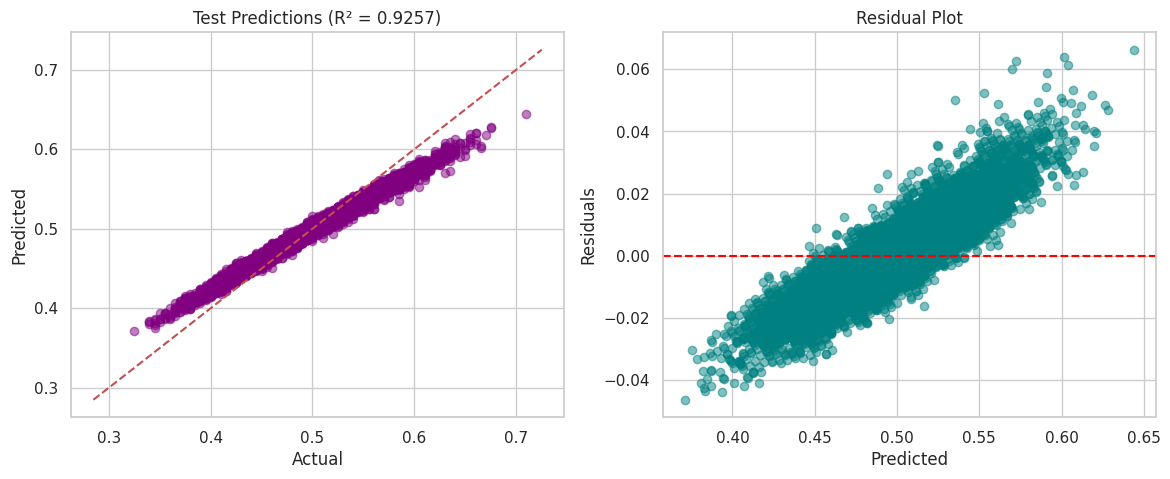

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].scatter(y_test, y_pred, alpha=0.5, color='purple')
ax[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
ax[0].set_xlabel('Actual')
ax[0].set_ylabel('Predicted')
ax[0].set_title(f'Test Predictions (R² = {r2_score(y_test, y_pred):.4f})')

residuals = y_test - y_pred
ax[1].scatter(y_pred, residuals, alpha=0.5, color='teal')
ax[1].axhline(0, color='red', linestyle='--')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Residuals')
ax[1].set_title('Residual Plot')

plt.show()

### Feature Importance (from CatBoost)

/tmp/ipython-input-1239418626.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[idx], y=feat_names[idx], palette='viridis')


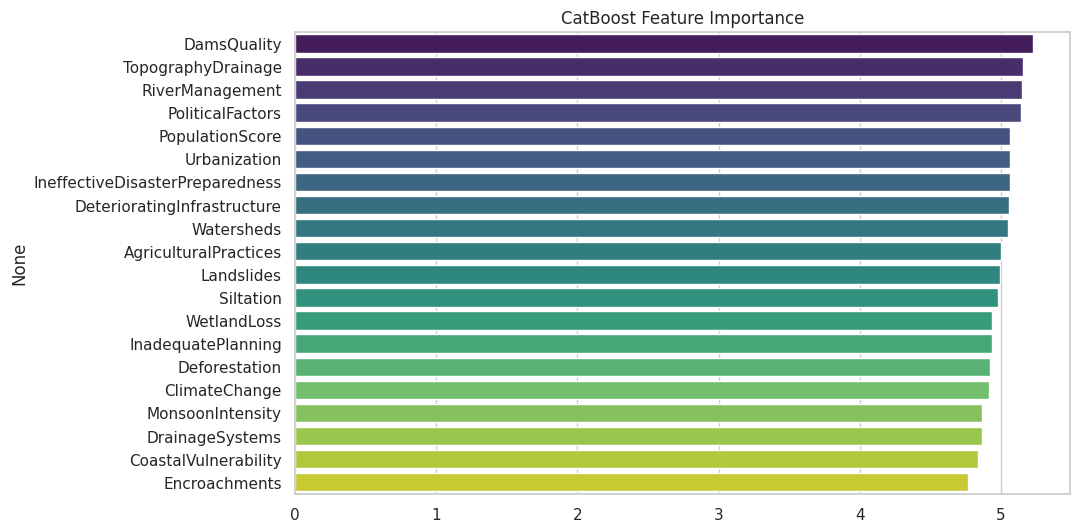

In [ ]:
importances = cat.get_feature_importance()
feat_names = X.columns
idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[idx], y=feat_names[idx], palette='viridis')
plt.title('CatBoost Feature Importance')
plt.show()